# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()


(891221, 85)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [4]:
print(feat_info.shape)
feat_info.head()

(85, 4)


attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

"""for index in feat_info.index:
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
    azdias.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)"""

In [5]:
# Identify missing or unknown data values and convert them to NaNs.

def string_to_list(x):
    new_list = []
    x = x[1:-1].split(',')
    for i in x:
        try:
            new_list.append(int(i))
        except:
            new_list.append(i)
    return new_list

feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(string_to_list)
feat_info.head()

attribute information_level         type missing_or_unknown  \
0              AGER_TYP            person  categorical             [-1,0]   
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]   
2             ANREDE_KZ            person  categorical             [-1,0]   
3         CJT_GESAMTTYP            person  categorical                [0]   
4     FINANZ_MINIMALIST            person      ordinal               [-1]   

      NA_tags  
0     [-1, 0]  
1  [-1, 0, 9]  
2     [-1, 0]  
3         [0]  
4        [-1]

In [6]:
att_index = feat_info.set_index('attribute')
na_azdias = azdias[:]
for column in na_azdias.columns:
    na_azdias[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)
na_azdias.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [7]:
na_azdias.isna().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
na_azdias.isnull().sum()


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
# Investigate patterns in the amount of missing data in each column.
missing_values_azdias= na_azdias.isnull().sum().to_frame()
labels=missing_values_azdias.index.to_series()

nan_data=missing_values_azdias.values.reshape(missing_values_azdias.shape[0]).tolist()
print(nan_data)
plt.title('NaN Values by Column')
plt.xticks(rotation=90)
plt.bar(labels,nan_data)



[685843, 2881, 0, 4854, 0, 0, 0, 0, 0, 0, 0, 392318, 4854, 0, 111196, 97632, 94572, 77792, 77792, 4854, 4854, 108315, 108164, 4854, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 111196, 73499, 889061, 111196, 0, 310267, 73499, 73499, 18348, 584612, 147988, 73499, 99611, 97008, 93148, 73969, 93148, 93148, 93148, 99352, 99352, 99352, 133324, 133324, 133324, 133324, 476524, 133324, 93740, 93740, 93740, 93155, 158064, 133324, 4854, 158064, 105800, 116515, 116515, 116515, 116515, 116515, 116515, 116515, 97375, 97274, 97375]


<Container object of 85 artists>

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_col=na_azdias.columns[na_azdias.isnull().sum()>200000]
print(outlier_col)
#Most columns have NaN values at around 100,000. We can consider outliers values which are above 200,000 which are six columns
na_col_azdias = na_azdias.drop(columns = outlier_col)
print(na_col_azdias.shape)
feat_info = feat_info.set_index('attribute').drop(outlier_col)
print(feat_info.shape)

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
(891221, 79)
(79, 4)


#### Discussion 1.1.2: Assess Missing Data in Each Column

By visualizing the number of missing values by column, it is apparent that there are many columns with missing values near 100,000. However, we can see that there are 6 columns with much higher values, which we identified to be the columns: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'. These columns, as outliers, were removed. The rest we left alone, as they are not of the ordinary compared to other columns and are rather common. Thus we are left with 79 columns(features). 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [11]:
# How much data is missing in each row of the dataset?
na_col_azdias.isnull().sum(axis=1).head()
# We can see different number of missing values per row

0    43
1     0
2     0
3     7
4     0
dtype: int64

In [12]:
#Create series showing number of rows with certain number of missing values. 
row_nan_data = na_col_azdias.isnull().sum(axis=1).value_counts(sort=False)
row_nan_data.head()

0    623209
1     15738
2     27926
3     17629
4     12607
dtype: int64

In [13]:
row_nan_data.shape
#49 different values of number of missing values. 

(49,)

<Container object of 49 artists>

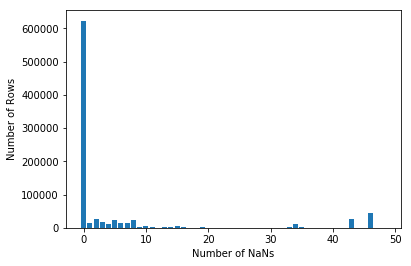

In [14]:
plt.xlabel('Number of NaNs')
plt.ylabel('Number of Rows')
plt.bar(np.arange(49), row_nan_data)


In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
subset1 = na_col_azdias[na_col_azdias.isnull().sum(axis=1)>20]
subset2 = na_col_azdias[na_col_azdias.isnull().sum(axis=1)<=20]

print(subset1.shape)
print(subset2.shape)


(93795, 79)
(797426, 79)


In [16]:
outlier_row = na_col_azdias.index[na_col_azdias.isnull().sum(axis=1)<=20]

outlier_row

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            891211, 891212, 891213, 891214, 891215, 891216, 891217, 891218,
            891219, 891220],
           dtype='int64', length=797426)

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
na_col_azdias.isnull().sum().head(10)

ALTERSKATEGORIE_GROB     2881
ANREDE_KZ                   0
CJT_GESAMTTYP            4854
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
dtype: int64

We can find 5 columns with no missing values here. We'll use ANREDE_KZ, FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER as our columns for comparison. 

In [18]:
na_azdias['FINANZ_MINIMALIST'].value_counts()
print(subset1.shape)


(93795, 79)


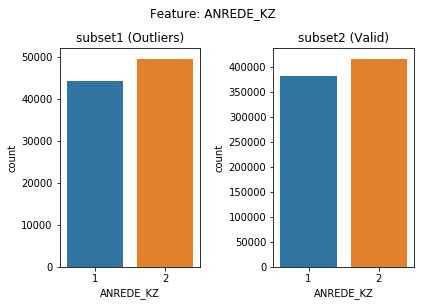

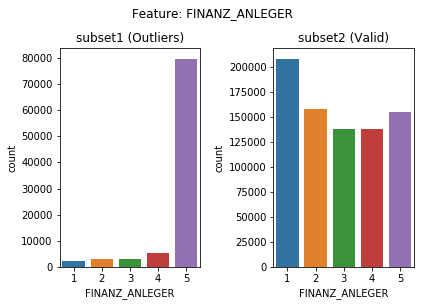

In [19]:
cols = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER']

def plot_distribution(feature):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"Feature: {feature}", y = 1.05)
    ax1.set_title("subset1 (Outliers)")
    ax2.set_title("subset2 (Valid)")
    sns.countplot(x=feature, ax=ax1, data=subset1)
    sns.countplot(x=feature, ax=ax2, data=subset2)
    fig.tight_layout()
for col in cols:
    plot_distribution(col)
#code borrowed and modified from Knowledge: https://knowledge.udacity.com/questions/546239 

#### Discussion 1.1.3: Assess Missing Data in Each Row

In the graphs above, we have plotted the distributions of data according to features(columns) with no missing data, according to our subsets with much missing data and those with less missing data. By analyzing the graphs, we can see that while the data distributions for the feature "ANREDE_KZ" are similar for both subsets, in the rest of the 4 features, there is a stark contrast in the distributions between the data with many missing values and data with less missing values. In these 4 cases, we can see that in the data with many missing values (subset1), there is a large skew in the data with one value having many more instances while in the data with less missing data (subset2), the heights of the bars are similar. We can thus argue that since there is a large difference, these are special instances and should be kept. If we were to drop this data, it could affect our overall outcome. However, for now, we will use the data with less missing values (subset2).


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?
print("categorical: ",(feat_info['type'] == 'categorical').sum())
print("mixed: ",(feat_info['type'] == 'mixed').sum())

categorical:  18
mixed:  6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_feat = feat_info[feat_info['type']=='categorical']
categorical = list(subset2[cols].dropna().unique().shape[0] for cols in categorical_feat.index)
print(categorical_feat.index)
categorical


Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object', name='attribute')


[2, 6, 6, 12, 2, 11, 5, 10, 5, 3, 4, 2, 2, 6, 7, 2, 9, 44]

In [22]:
#Binary variables are those in ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ', 'VERS_TYP','OST_WEST_KZ']
#'OST_WEST_KZ' is the binary variable with non-numeric values (0, and "W"). We will replace "W" with 1
multi_level = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
len(multi_level)

13

In [146]:
# Re-encode categorical variable(s) to be kept in the analysis.
clean_azdias = pd.get_dummies(subset2, columns = multi_level)

clean_azdias['OST_WEST_KZ'].replace('O',1, inplace=True)
clean_azdias['OST_WEST_KZ'].replace("W",2, inplace =True)

clean_azdias.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   
5                 5               2                      2                 5   

   GREEN_AVANTGARDE  HEALTH_TYP        ...          CAMEO_DEU_2015_7E  \
1                 0         3.0        ...                          0   
2                 1         3.0        ...                          0   
3                 0         2.0        ...                          0   
4                 0         3.0        ...                          0   
5                 0         3.0        ...                          0   

   CAMEO_DEU_2015_8A  CAMEO_DEU_2015_8B  CAMEO_DEU_2015_8C  CAMEO_DEU_2015_8D  \
1                  1                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   
5                  0                  0                  1                  0   

   CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  \
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   
5                  0                  0                  0                  0   

   CAMEO_DEU_2015_9E  
1                  0  
2                  0  
3                  0  
4                  0  
5                  0  

[5 rows x 194 columns]

#### Discussion 1.2.1: Re-Encode Categorical Features
We found a total of 18 categorical variables, 5 of which were binary, and the other 13 being multi-level categoricals. The binary variables were 
- ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP','OST_WEST_KZ'] 

and the multi-level categoricals were 
- ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'].

Of these, the binary variable 'OST_WEST_KZ' was a variable with non-numeric values (0,W), and we changed this to (1,2). For the multi-level categoricals, we did one-hot encoding with get_dummies (). We did not drop any categorical variables. 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [147]:
mixed_feat = feat_info[feat_info['type']=='mixed']
print(mixed_feat.index)
print(len(mixed_feat.index))

Index(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'],
      dtype='object', name='attribute')
6


In [148]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# The new two variables "PRAEGENDE_JUGENDJAHRE_decade" and "PRAEGENDE_JUGENDJAHRE_movement" will each have values of 4-8 (for the 40's, 50's, so forth)
# and 1-2 (1 for Mainstream, and 2 for Avantgarde)
def decades(x) :
    if x in [1,2]:
        return 4
    elif x in [3,4]:
        return 5
    elif x in [5,6,7]:
        return 6
    elif x in [8,9]:
        return 7
    elif x in [10,11,12,13]:
        return 8
    else:
        return 9
def movement(x) :
    if x in [1, 3, 5, 8, 10, 12, 14]:
        return 1
    else:
        return 2
clean_azdias["PRAEGENDE_JUGENDJAHRE_decade"] = clean_azdias["PRAEGENDE_JUGENDJAHRE"].apply(decades)
clean_azdias["PRAEGENDE_JUGENDJAHRE_movement"] = clean_azdias["PRAEGENDE_JUGENDJAHRE"].apply(movement)

clean_azdias.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)

In [182]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
clean_azdias["CAMEO_INTL_2015_wealth"] = clean_azdias["CAMEO_INTL_2015"]
clean_azdias["CAMEO_INTL_2015_life"] = clean_azdias["CAMEO_INTL_2015"]

clean_azdias["CAMEO_INTL_2015_wealth"] = clean_azdias["CAMEO_INTL_2015_wealth"].replace(['11', '12', '13', '14', '15'], 1)
clean_azdias["CAMEO_INTL_2015_wealth"] = clean_azdias["CAMEO_INTL_2015_wealth"].replace(['21', '22', '23', '24', '25'], 2)
clean_azdias["CAMEO_INTL_2015_wealth"] = clean_azdias["CAMEO_INTL_2015_wealth"].replace(['31', '32', '33', '34', '35'], 3)
clean_azdias["CAMEO_INTL_2015_wealth"] = clean_azdias["CAMEO_INTL_2015_wealth"].replace(['41', '42', '43', '44', '45'], 4)
clean_azdias["CAMEO_INTL_2015_wealth"] = clean_azdias["CAMEO_INTL_2015_wealth"].replace(['51', '52', '53', '54', '55'], 5)

clean_azdias["CAMEO_INTL_2015_life"] = clean_azdias["CAMEO_INTL_2015_life"].replace(['11', '21', '31', '41', '51'], 1)
clean_azdias["CAMEO_INTL_2015_life"] = clean_azdias["CAMEO_INTL_2015_life"].replace(['12', '22', '32', '42', '52'], 2)
clean_azdias["CAMEO_INTL_2015_life"] = clean_azdias["CAMEO_INTL_2015_life"].replace(['13', '23', '33', '43', '53'], 3)
clean_azdias["CAMEO_INTL_2015_life"] = clean_azdias["CAMEO_INTL_2015_life"].replace(['14', '24', '34', '44', '54'], 4)
clean_azdias["CAMEO_INTL_2015_life"] = clean_azdias["CAMEO_INTL_2015_life"].replace(['15', '25', '35', '45', '55'], 5)

clean_azdias.drop("CAMEO_INTL_2015", axis=1, inplace=True)
clean_azdias.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   
5                 5               2                      2                 5   

   GREEN_AVANTGARDE  HEALTH_TYP          ...           CAMEO_DEU_2015_9B  \
1                 0         3.0          ...                           0   
2                 1         3.0          ...                           0   
3                 0         2.0          ...                           0   
4                 0         3.0          ...                           0   
5                 0         3.0          ...                           0   

   CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
1                  0                  0                  0   
2                  0                  0                  0   
3                  0                  0                  0   
4                  0                  0                  0   
5                  0                  0                  0   

   PRAEGENDE_JUGENDJAHRE_decade  PRAEGENDE_JUGENDJAHRE_movement  \
1                             9                               1   
2                             9                               2   
3                             7                               1   
4                             7                               1   
5                             5                               1   

   CAMEO_INTL_2015_wealth  CAMEO_INTL_2015_life  PLZ8_BAUMAX_homes  \
1                     5.0                   1.0                1.0   
2                     2.0                   4.0                1.0   
3                     1.0                   2.0                1.0   
4                     4.0                   3.0                2.0   
5                     5.0                   4.0                1.0   

   PLZ8_BAUMAX_business  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
5                   0.0  

[5 rows x 194 columns]

In [150]:
# "PLZ8_BAUMAX" has denotes most common building within the microcell with 1-5 being family homes with difference in family homes and 5 
# being mainly business buildings. We will make two new variables "PLZ8_BAUMAX_homes" and "PLZ8_BAUMAX_business". 5 will be converted 
#to 0 for "PLZ8_BAUMAX_homes", and 1-4 will be changed to 0 in "PLZ8_BAUMAX_business", as they each show low values in homes and business
#buildings respectively.
def homes(x):
    if x in range(1,5):
        return x
    if x == 5:
        return 0
    
def business(x):
    if x in range(1,5):
        return 0
    if x ==5:
        return x
clean_azdias["PLZ8_BAUMAX_homes"] = clean_azdias["PLZ8_BAUMAX"].apply(homes)
clean_azdias["PLZ8_BAUMAX_business"] = clean_azdias["PLZ8_BAUMAX"].apply(business)
clean_azdias.drop("PLZ8_BAUMAX", axis = 1, inplace =True)
clean_azdias.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   
5                 5               2                      2                 5   

   GREEN_AVANTGARDE  HEALTH_TYP          ...           CAMEO_DEU_2015_9B  \
1                 0         3.0          ...                           0   
2                 1         3.0          ...                           0   
3                 0         2.0          ...                           0   
4                 0         3.0          ...                           0   
5                 0         3.0          ...                           0   

   CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
1                  0                  0                  0   
2                  0                  0                  0   
3                  0                  0                  0   
4                  0                  0                  0   
5                  0                  0                  0   

   PRAEGENDE_JUGENDJAHRE_decade  PRAEGENDE_JUGENDJAHRE_movement  \
1                             9                               1   
2                             9                               2   
3                             7                               1   
4                             7                               1   
5                             5                               1   

   CAMEO_INTL_2015_wealth  CAMEO_INTL_2015_life  PLZ8_BAUMAX_homes  \
1                      51                    51                1.0   
2                      24                    24                1.0   
3                      12                    12                1.0   
4                      43                    43                2.0   
5                      54                    54                1.0   

   PLZ8_BAUMAX_business  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
5                   0.0  

[5 rows x 197 columns]

In [151]:
clean_azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE'], axis = 1, inplace =True)
clean_azdias.shape

(797426, 194)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Mixed-value Features:
- ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']

Of these 6 features, 3 were kept and 3 were dropped. 
Dropped Features: 
- 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE'

These three were dropped for similar reasons. Both 'LP_LEBENSPHASE_FEIN' and 'LP_LEBENSPHASE_GROB' denoted Life Stages on different scales, but the labels each value signified carried many meanings simultaneously. The labels had information regarding income and family types, but they were not easily divided, so the decision was made to drop them, as they would only provide needlessly complex data. 'WOHNLAGE' had labels regarding the neighborhood quality OR rural flag. Because this feature contains information regarding either only one or the other, I predicted that it would lead to missing values in both labels, and decided to drop the feature altogether.

Features Kept:
- 'PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015', 'PLZ8_BAUMAX'

The information denoted within these features were all easily divided into two labels. 'PRAEGENDE_JUGENDJAHRE' was divided into features regarding the generation by decade and movement, and 'CAMEO_INTL_2015' was divided into wealth and lifestyle typology. 'PLZ8_BAUMAX' denoted information regarding most common building type within the microcell. We divided this into two features "PLZ8_BAUMAX_homes" and "PLZ8_BAUMAX_business". "PLZ8_BAUMAX_homes" is new feature showing the size of the family home if it is the most common building type in the microcell. So, if the original value was 1-4, we kept this in "PLZ8_BAUMAX_homes" and changed the orignal 5's to 0's as this meant that the most common building type was not a family home. On the other hand "PLZ8_BAUMAX_homes" showed cases where the most common building *was* a business building, changing values 1-4 to 0, and 5's to 1, essentially becoming a binary categorical variable. 
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [152]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

feat_info[feat_info['type'] == 'ordinal'].shape[0]+feat_info[feat_info['type'] == 'interval'].shape[0]+feat_info[feat_info['type'] == 'numeric'].shape[0]
#subset2 had 79 features, of which 18 were categorical and 6 being mixed. The rest should be the numeric, interval and ordinal type
#features the total of which should be 55, as so. 

55

In [153]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
obj_col = clean_azdias.columns[(clean_azdias.dtypes== object)]
#print(obj_col)
#clean_azdias.columns[44]
#clean_azdias.iloc[:,42].dtypes
obj_col

Index(['CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life'], dtype='object')

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [154]:
outlier_col

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [184]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    na_df = df[:]
    for column in na_df.columns:
        na_df[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)
    
    # remove selected columns and rows, ...
    na_col_df = na_df.drop(columns = outlier_col)
    subset_df = na_col_df[na_col_df.isnull().sum(axis=1)<=20]
    
    # select, re-encode, and engineer column values.
    clean_df = pd.get_dummies(subset_df, columns = multi_level)
    clean_df['OST_WEST_KZ'].replace('O',1, inplace=True)
    clean_df['OST_WEST_KZ'].replace("W",2, inplace =True)
    clean_df["PRAEGENDE_JUGENDJAHRE_decade"] = clean_df["PRAEGENDE_JUGENDJAHRE"].apply(decades)
    clean_df["PRAEGENDE_JUGENDJAHRE_movement"] = clean_df["PRAEGENDE_JUGENDJAHRE"].apply(movement)
    clean_df.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)
    clean_df["CAMEO_INTL_2015_wealth"] = clean_df["CAMEO_INTL_2015"]
    clean_df["CAMEO_INTL_2015_life"] = clean_df["CAMEO_INTL_2015"]
    clean_df["CAMEO_INTL_2015_wealth"] = clean_df["CAMEO_INTL_2015_wealth"].replace(['11', '12', '13', '14', '15'], 1)
    clean_df["CAMEO_INTL_2015_wealth"] = clean_df["CAMEO_INTL_2015_wealth"].replace(['21', '22', '23', '24', '25'], 2)
    clean_df["CAMEO_INTL_2015_wealth"] = clean_df["CAMEO_INTL_2015_wealth"].replace(['31', '32', '33', '34', '35'], 3)
    clean_df["CAMEO_INTL_2015_wealth"] = clean_df["CAMEO_INTL_2015_wealth"].replace(['41', '42', '43', '44', '45'], 4)
    clean_df["CAMEO_INTL_2015_wealth"] = clean_df["CAMEO_INTL_2015_wealth"].replace(['51', '52', '53', '54', '55'], 5)
    clean_df["CAMEO_INTL_2015_life"] = clean_df["CAMEO_INTL_2015_life"].replace(['11', '21', '31', '41', '51'], 1)
    clean_df["CAMEO_INTL_2015_life"] = clean_df["CAMEO_INTL_2015_life"].replace(['12', '22', '32', '42', '52'], 2)
    clean_df["CAMEO_INTL_2015_life"] = clean_df["CAMEO_INTL_2015_life"].replace(['13', '23', '33', '43', '53'], 3)
    clean_df["CAMEO_INTL_2015_life"] = clean_df["CAMEO_INTL_2015_life"].replace(['14', '24', '34', '44', '54'], 4)
    clean_df["CAMEO_INTL_2015_life"] = clean_df["CAMEO_INTL_2015_life"].replace(['15', '25', '35', '45', '55'], 5)
    clean_df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    clean_df["PLZ8_BAUMAX_homes"] = clean_df["PLZ8_BAUMAX"].apply(homes)
    clean_df["PLZ8_BAUMAX_business"] = clean_df["PLZ8_BAUMAX"].apply(business)
    clean_df.drop("PLZ8_BAUMAX", axis = 1, inplace =True)
    clean_df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE'], axis = 1, inplace =True)
    clean_df['GEBAEUDETYP_5.0'] = np.nan #this was included because, the customer file did not have an instance
    #of 5.0 in the "GEBAEUDETYP" column, when using get_dummies, while the general population did. Thus, this 
    #column was arbitrarily added. 

    # Return the cleaned dataframe.
    return clean_df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [185]:
missing_values_azdias= clean_azdias.isnull().sum().to_frame()
labels=missing_values_azdias.index.to_series()

nan_data=missing_values_azdias.values.reshape(missing_values_azdias.shape[0]).tolist()
print(nan_data)
plt.title('NaN Values by Column')
plt.xticks(rotation=90)
plt.bar(labels,nan_data)

[2784, 0, 0, 0, 0, 0, 0, 0, 0, 36417, 4634, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 36417, 0, 0, 0, 58900, 0, 6330, 3728, 68, 0, 0, 39536, 39536, 39536, 39536, 39536, 591, 591, 591, 5, 64433, 39536, 4634, 64433, 12257, 22729, 22729, 22729, 22729, 22729, 22729, 4218, 4118, 4218, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6003, 6003, 22729, 22729]


<Container object of 194 artists>

In [186]:
clean_azdias.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   
5                 5               2                      2                 5   

   GREEN_AVANTGARDE  HEALTH_TYP          ...           CAMEO_DEU_2015_9B  \
1                 0         3.0          ...                           0   
2                 1         3.0          ...                           0   
3                 0         2.0          ...                           0   
4                 0         3.0          ...                           0   
5                 0         3.0          ...                           0   

   CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
1                  0                  0                  0   
2                  0                  0                  0   
3                  0                  0                  0   
4                  0                  0                  0   
5                  0                  0                  0   

   PRAEGENDE_JUGENDJAHRE_decade  PRAEGENDE_JUGENDJAHRE_movement  \
1                             9                               1   
2                             9                               2   
3                             7                               1   
4                             7                               1   
5                             5                               1   

   CAMEO_INTL_2015_wealth  CAMEO_INTL_2015_life  PLZ8_BAUMAX_homes  \
1                     5.0                   1.0                1.0   
2                     2.0                   4.0                1.0   
3                     1.0                   2.0                1.0   
4                     4.0                   3.0                2.0   
5                     5.0                   4.0                1.0   

   PLZ8_BAUMAX_business  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
5                   0.0  

[5 rows x 194 columns]

In [187]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = Imputer(strategy='median') 
impute_azdias = pd.DataFrame(imputer.fit_transform(clean_azdias))

impute_azdias.columns = clean_azdias.columns

impute_azdias.index = clean_azdias.index

In [188]:
# Apply feature scaling to the general population demographics data.
scaler=StandardScaler()
azdias_scaled=scaler.fit_transform(impute_azdias)


### Discussion 2.1: Apply Feature Scaling

By plotting the number of NaN's by column, we can see that at most we have missing values at approximately 60000, which is less than a tenth of our entries, and again, is only for just a few of our columns. We shouldn't expect too drastic changes by applying imputation before scaling the data. In this case, we use "median" as our strategy. Finally, we use the Standard Scaler after imputing our missing values. 


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [189]:
# Apply PCA to the data.
pca = PCA()
data_pca = pca.fit_transform(azdias_scaled)

#Taken from helper_functions from the course!
def do_pca(n_components, data):
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

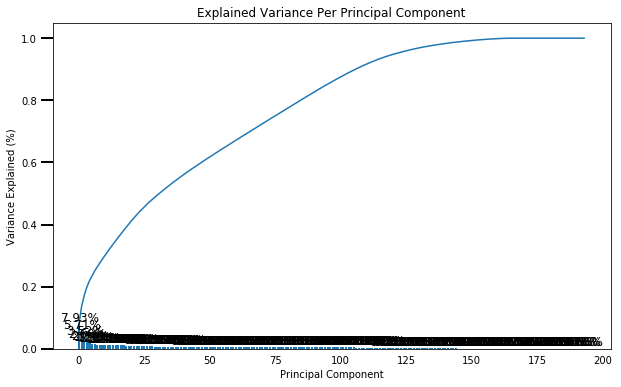

In [190]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
scree_plot(pca)

We can approximate through the graph that with about 90 components, we will reach a little over 80 percent variance. This seems appropriate, so we will use 90 as our number of components

In [191]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, data_pca = do_pca(90, impute_azdias)


### Discussion 2.2: Perform Dimensionality Reduction
The variance reaches about 80% at about 90 components. This seemed like an appropriate percentage of variance at less than 50% of the original features, so we went this number of 90 components for the PCA. 

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [192]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_nth_component(pca, n):
    weight_df = pd.DataFrame({'weight': pca.components_[n]}, index=impute_azdias.columns)
    print("Most signficant features of component", n)
    print(weight_df.sort_values(by=['weight']).head(5))
    print(weight_df.sort_values(by=['weight']).tail(5))
print_nth_component(pca, 1)


Most signficant features of component 1
                                weight
PRAEGENDE_JUGENDJAHRE_decade -0.232040
FINANZ_SPARER                -0.228997
FINANZ_UNAUFFAELLIGER        -0.216850
SEMIO_REL                    -0.215665
SEMIO_TRADV                  -0.208665
                        weight
SEMIO_LUST            0.163926
SEMIO_ERL             0.180255
ZABEOTYP_3            0.199883
FINANZ_VORSORGER      0.220169
ALTERSKATEGORIE_GROB  0.233985


In [193]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_nth_component(pca, 2)


Most signficant features of component 2
              weight
ANREDE_KZ  -0.345956
SEMIO_KAEM -0.316819
SEMIO_DOM  -0.285255
SEMIO_KRIT -0.267755
SEMIO_ERL  -0.208687
               weight
FINANZTYP_5  0.133560
SEMIO_KULT   0.252401
SEMIO_SOZ    0.257072
SEMIO_FAM    0.261371
SEMIO_VERT   0.319782


In [194]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_nth_component(pca, 3)


Most signficant features of component 3
                      weight
LP_STATUS_GROB_4.0 -0.190347
LP_STATUS_FEIN_9.0 -0.179207
BALLRAUM           -0.172774
INNENSTADT         -0.169319
KKK                -0.166924
                                  weight
EWDICHTE                        0.206228
LP_STATUS_FEIN_10.0             0.243469
LP_STATUS_GROB_5.0              0.243469
PRAEGENDE_JUGENDJAHRE_movement  0.282956
GREEN_AVANTGARDE                0.293122


### Discussion 2.3: Interpret Principal Components

In the first principal component, we can find that ALTERSKATEGORIE_GROB(+), PRAEGENDE_JUGENDJAHRE_decade(-), FINANZ_SPARER(-) are the top 3 features that have the largest impact on the component. It is important to note, the positive and negative values indicate the direction of each feature relative to the principal component, so whether one is positive or negative is not significant in itself. Rather, the absolute value of these weights show the overall impact the feature has on the principal component. Thus, in the first principal component, I have listed the top three features with the largest absolute value, regardless of their direction.
This is the same for the other two principal components. The second component was most affected by ANREDE_KZ(+), SEMIO_VERT(+), SEMIO_KAEM(-), and the third component by GREEN_AVANTGARDE(+), PRAEGENDE_JUGENDJAHRE_movement(+), LP_STATUS_GROB_5.0(+). 

One interesting thing about the third component, is that the two most negatively weighted features, LP_STATUS_GROB_4.0, LP_STATUS_FEIN_9.0 both correspond to the social status of being homeowners. Also, two of the most positively weighted features LP_STATUS_FEIN_10.0, LP_STATUS_GROB_5.0 correspond to the social status of being top earners. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [195]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
def get_kmeans_score(data, center):
    kmeans = MiniBatchKMeans(n_clusters=center, n_init = 10, random_state = 42)

    model = kmeans.fit(data)
    
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,31))

for center in centers:
    scores.append(get_kmeans_score(data_pca, center))
    
    

In [196]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [197]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=9, random_state = 42)

model = kmeans.fit(data_pca)

azdias_prediction = model.predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population

Here, we used the MiniBatchKMeans method because KMeans was taking waaaaay too much time. We calculated and plotted the SSE for each number of clusters from 1-30, to find the elbow. I decided to use 9 as our number, as this is the point where we can see the slope visibly decreases. 


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [198]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   
3                      1                 2    ...            3.0         2.0   
4                      5                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  

[5 rows x 85 columns]

In [199]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
clean_customers = clean_data(customers)
impute_customers = pd.DataFrame(imputer.transform(clean_customers))
impute_customers.columns = clean_customers.columns

impute_customers.index = clean_customers.index
scaled_customers = scaler.transform(impute_customers)


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [200]:
impute_customers.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0        1.0                5.0            1.0   
2                   4.0        2.0                5.0            1.0   
3                   4.0        1.0                5.0            1.0   
4                   3.0        1.0                3.0            1.0   
5                   3.0        1.0                5.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0               5.0             1.0                    2.0               2.0   
2               5.0             1.0                    4.0               4.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             4.0                    5.0               2.0   
5               5.0             1.0                    2.0               3.0   

   GREEN_AVANTGARDE  HEALTH_TYP       ...         CAMEO_DEU_2015_9C  \
0               1.0         1.0       ...                       0.0   
2               1.0         2.0       ...                       0.0   
3               0.0         2.0       ...                       0.0   
4               0.0         3.0       ...                       0.0   
5               1.0         3.0       ...                       0.0   

   CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_decade  \
0                0.0                0.0                           5.0   
2                0.0                0.0                           5.0   
3                0.0                0.0                           4.0   
4                0.0                0.0                           7.0   
5                0.0                0.0                           5.0   

   PRAEGENDE_JUGENDJAHRE_movement  CAMEO_INTL_2015_wealth  \
0                             2.0                     1.0   
2                             2.0                     3.0   
3                             1.0                     2.0   
4                             1.0                     4.0   
5                             2.0                     3.0   

   CAMEO_INTL_2015_life  PLZ8_BAUMAX_homes  PLZ8_BAUMAX_business  \
0                   3.0                1.0                   0.0   
2                   4.0                3.0                   0.0   
3                   4.0                1.0                   0.0   
4                   1.0                2.0                   0.0   
5                   4.0                1.0                   0.0   

   GEBAEUDETYP_5.0  
0              0.0  
2              0.0  
3              0.0  
4              0.0  
5              0.0  

[5 rows x 194 columns]

In [201]:
customer_pca = pca.transform(scaled_customers)
customer_prediction = model.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

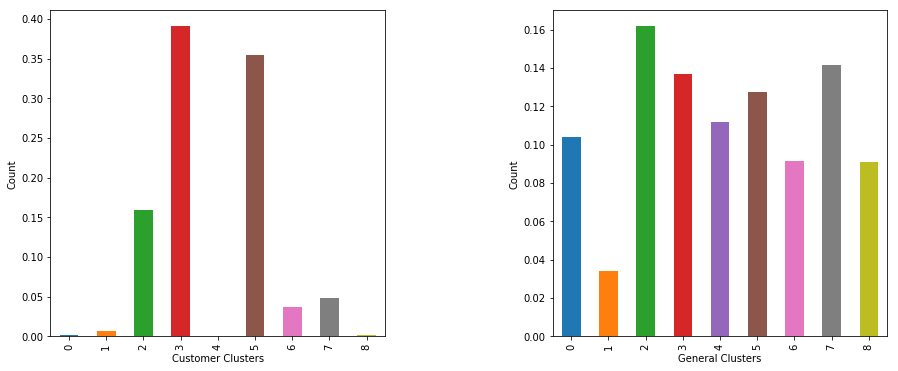

In [202]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize = (15,6))
plt. subplots_adjust(wspace = 0.5, hspace = 0.5)

plt.subplot(nrows, ncols, 1, xlabel = "Customer Clusters", ylabel = "Count")
pd.DataFrame(customer_prediction).iloc[:,0].value_counts(sort=False, normalize = True).plot(kind='bar')
plt.subplot(nrows, ncols, 2, xlabel = "General Clusters", ylabel = "Count")
pd.DataFrame(azdias_prediction).iloc[:,0].value_counts(sort=False, normalize = True).plot(kind='bar')
plt.show()

In [209]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
#We can see that cluster 3 is vastly overrepresented in the customer data compared to the general population. 
centroid_3 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[3])).round(1)
cluster_3 = pd.Series(data = centroid_3 , index=clean_azdias.columns)
cluster_3

ALTERSKATEGORIE_GROB              3.6
ANREDE_KZ                         2.0
FINANZ_MINIMALIST                 2.6
FINANZ_SPARER                     1.8
FINANZ_VORSORGER                  4.4
FINANZ_ANLEGER                    2.1
FINANZ_UNAUFFAELLIGER             1.7
FINANZ_HAUSBAUER                  4.2
GREEN_AVANTGARDE                  0.1
HEALTH_TYP                        2.0
RETOURTYP_BK_S                    4.2
SEMIO_SOZ                         2.9
SEMIO_FAM                         2.2
SEMIO_REL                         2.1
SEMIO_MAT                         2.7
SEMIO_VERT                        2.7
SEMIO_LUST                        5.4
SEMIO_ERL                         6.5
SEMIO_KULT                        1.9
SEMIO_RAT                         3.4
SEMIO_KRIT                        6.0
SEMIO_DOM                         5.8
SEMIO_KAEM                        6.0
SEMIO_PFLICHT                     2.9
SEMIO_TRADV                       2.4
SOHO_KZ                           0.0
VERS_TYP    

In [217]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
#Cluster 8 is barely represented in the customer data, if at all.
centroid_8 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[8])).round(1)
cluster_8 = pd.Series(data = centroid_8 , index=clean_azdias.columns)
cluster_8.head()


ALTERSKATEGORIE_GROB    1.9
ANREDE_KZ               1.0
FINANZ_MINIMALIST       1.9
FINANZ_SPARER           4.4
FINANZ_VORSORGER        2.0
dtype: float64

In [218]:
#Arbitrarily pick features based on most weighted features in the earlier principal component analysis. I did not include features
#regarding SEMIO or FINANZ, because these features denoted values regarding another variable AFTER being classified. The features chosen 
#here are ones that give clear meanings. 
features = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'PRAEGENDE_JUGENDJAHRE_decade', 'PRAEGENDE_JUGENDJAHRE_movement', 
            'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life', 'GREEN_AVANTGARDE', 'LP_STATUS_GROB_4.0', 'LP_STATUS_FEIN_9.0', 
            'LP_STATUS_FEIN_10.0', 'LP_STATUS_GROB_5.0']

In [221]:
compare_clusters = pd.DataFrame(data = [cluster_3, cluster_8], index = ['cluster_3', 'cluster_8'], columns = features)
compare_clusters

ALTERSKATEGORIE_GROB  ANREDE_KZ  PRAEGENDE_JUGENDJAHRE_decade  \
cluster_3                   3.6        2.0                           6.3   
cluster_8                   1.9        1.0                           8.8   

           PRAEGENDE_JUGENDJAHRE_movement  CAMEO_INTL_2015_wealth  \
cluster_3                             1.1                     4.2   
cluster_8                             1.1                     4.2   

           CAMEO_INTL_2015_life  GREEN_AVANTGARDE  LP_STATUS_GROB_4.0  \
cluster_3                   2.8               0.1                 0.0   
cluster_8                   2.1               0.1                 0.0   

           LP_STATUS_FEIN_9.0  LP_STATUS_FEIN_10.0  LP_STATUS_GROB_5.0  
cluster_3                 0.0                  0.0                 0.0  
cluster_8                 0.0                  0.0                 0.0

### Discussion 3.3: Compare Customer Data to Demographics Data

I decided to analyze the top 2 overrepresented clusters, and the top 2 underrepresented clusters. It is important to note that cluster 3 and 5 makes up over 30% of the customer data each, so we will put more emphasis on the findings from these clusters. Features to analyze in the dataframe above were abritrarily chosen based on findings from the earlier principal component analysis. From that analysis, I chose the features that were categorical variables, and thus easier to gain information from.
I will now report my findings by each chosen feature.

-ALTERSKATEGORIE_GROB
This feature represents the estimated age group. With cluster 3 of the overrepresented cluster having a value over 3, we can infer that those who are over 45 are more popular with this company, with those in the underrepresented group being younger, between 30~45. This is one feature where we can see a clear divide in one of the clusters.

-ANREDE_KZ
This feature shows the gender. In this data, we can find that most in the overrepresented cluster are female, while those in the underrepresented cluster are male. There is a divide in this data as well, and can infer that females are more popular with this company. 

-PRAEGENDE_JUGENDJAHRE_decade
This feature represents the decade of the dominating movement of the person's youth. We can see here that the overrepresented cluster 3 has a value at 6.3, and the underrepresented cluster has a value over 8. This shows that the group that is more popular with the company is more older, as their youth was in the 60's. Those whose youth were in the 80's were in both overrepresented and underrepresented clusters, and this lines up with our findings in the ALTERSKATEGORIE_GROB feature.

-PRAEGENDE_JUGENDJAHRE_movement
This feature represents the dominating movement of the persons youth, either Mainstream(1) or Avantgarde(2). We can see that the dominating movement was Mainstream for both groups.  

-CAMEO_INTL_2015_wealth
This feature shows the same value for both clusters, so it is difficult to infer anything from this data. However, it shows both clusters are of people who are less affluent.

-CAMEO_INTL_2015_life
We can see that the overrepresented cluster has a value closer to 3, so they are families with school age children, where as the underrepresented cluster has a value near 2, meaning they are young couples with children. This lines up mostly with our data from ALTERSKATEGORIE_GROB and PRAEGENDE_JUGENDJAHRE_decade, showing that those who are older will be more popular with the company. 

-GREEN_AVANTGARDE, LP_STATUS_GROB_4.0, LP_STATUS_FEIN_9.0, LP_STATUS_FEIN_10.0, LP_STATUS_GROB_5.0
These features all have similar values between the groups so we cannot infer much information regarding the popularity with the company. However, we can see that they are in line with the rest of our data, with GREEN_AVANTGARDE both being near 0, so not being part of green avangarde, as avangarde was not the dominating movement of their time, and as they are all less affluent, as shown in CAMEO_INTL_2015_wealth, they do not have values near 1 in LP_STATUS_GROB_4.0, LP_STATUS_FEIN_9.0, LP_STATUS_FEIN_10.0, LP_STATUS_GROB_5.0, which each indicate houseowners and top earners. 

So to conclude, from this analysis, we can infer that those who are older and are female are more likely to be popular with the company. 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.